In [1]:
import numpy as np
import chess 
import chess.engine
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
sns.set()

In [2]:
def game_end(board):
    """
    board.is_checkmate()
    board.is_stalemate()
    board.outcome()
    board.can_claim_draw()
    board.can_claim_threefold_repetition()
    board.can_claim_fifty_moves()
    board.is_insufficient_material()
    board.is_fivefold_repetition()
    board.is_seventyfive_moves()
    """
    if board.is_game_over():
        return True
    if board.can_claim_draw():
        return True
    return False

In [3]:
def play_stockfish(engine, f_obj = None, time_limit = 0.01):
    board = chess.Board()
    while(not game_end(board)):
        move = engine.play(board, chess.engine.Limit(time = time_limit)).move
        board.push(move)
        if f_obj is not None:
            f_obj.write("%s\n" % board.fen())

In [4]:
def stock_eval(board, time_limit = 0.01):
    stockfish = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
    engine = chess.engine.SimpleEngine.popen_uci(stockfish)
    result = engine.analyse(board, chess.engine.Limit(time = time_limit))
    engine.quit()
    return result['score'].white() #check the datatype

In [4]:
stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
n_games = 10000
f_obj = open('stockfish_fen.txt', 'a')
for i in tqdm(range(n_games)):
    play_stockfish(engine, f_obj)
engine.quit()
f_obj.close()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [4:31:53<00:00,  1.63s/it]


CLUSTERING 

In [5]:
def embed_fen(fen):
    board = chess.Board(fen)
    embed = np.zeros(64*12)
    piece_dict = {'K': 0, 'Q': 1, 'R': 2, 'B': 3, 'N': 4, 'P': 5, 'k': 6, 'q': 7, 'r': 8, 'b': 9, 'n': 10, 'p': 11}
    for square, piece in board.piece_map().items():
        embed[square*12 + piece_dict[str(piece)]] = 1
    #embed[-1] = int(str(stock_eval(board)))/100 #to include stockfish evaluation
    return embed

In [6]:
def decode_embed(embed):
    piece_dict = {id:piece for id, piece in zip(np.arange(12), ['K', 'Q', 'R', 'B', 'N', 'P', 'k', 'q', 'r', 'b', 'n', 'p'])}
    piece_loc = np.arange(len(embed))[embed == 1]
    board = chess.Board(None)
    for loc in piece_loc:
        sq = loc//12
        p = piece_dict[loc % 12]
        board.set_piece_at(sq, chess.Piece.from_symbol(p))
    return board

In [7]:
#loading the stockfish fens and transforming them into embeddings
with open('stockfish_fen.txt', 'r') as sf:
    stock_fen = [line.strip() for line in sf.readlines()]
#sampling 100000 positions for clustering
samp_fen = list(set(random.sample(stock_fen, 100000)))
samp_embed = np.array([embed_fen(fen) for fen in tqdm(samp_fen)])

100%|█████████████████████████████████████████████████████████████████████████| 90210/90210 [00:08<00:00, 11188.21it/s]


In [40]:
#K-Means clustering
n_clusters = np.arange(100, 1100, 100)
#elbow curve plotting
wcss = []
for n in n_clusters:
    kmeans = KMeans(n_clusters = n, random_state = 42, n_init = 'auto')
    kmeans.fit(samp_embed)
    wcss.append(kmeans.inertia_)

KeyboardInterrupt: 

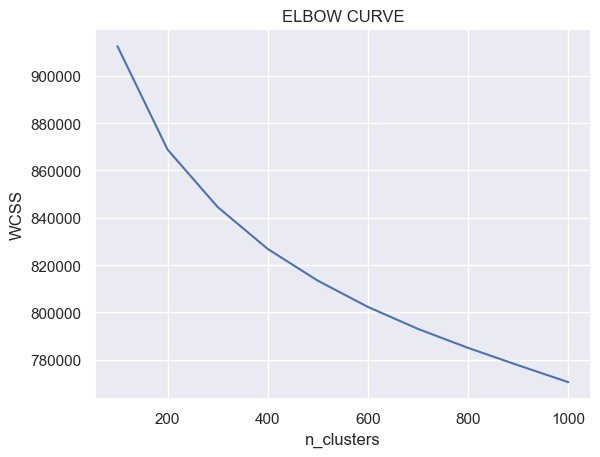

In [37]:
plt.plot(n_clusters, wcss)
plt.title('ELBOW CURVE')
plt.xlabel('n_clusters')
plt.ylabel('WCSS')
plt.show()
#from the graph n = 200 is chosen

In [9]:
#best model
k_means_best = KMeans(n_clusters = 200, random_state = 42, n_init = 'auto')
k_means_best.fit(samp_embed)

KMeans(n_clusters=200, n_init='auto', random_state=42)

In [10]:
#generating similar position pairs for training the embedding model
cluster_ids = k_means_best.labels_
for i in range(200):
    fen_cluster = samp_embed[cluster_ids == i]
    if len(fen_cluster) % 2:
        fen_cluster = fen_cluster[:-1]
    shape = fen_cluster.shape
    random.shuffle(fen_cluster)
    if not i:
        x_train = fen_cluster.reshape(shape[0]//2, 2, shape[1])
    else:
        x_train = np.concatenate((x_train, fen_cluster.reshape(shape[0]//2, 2, shape[1])), axis = 0)

BUILDING THE NEURAL NETWORK MODEL FOR DIMENSIONALITY REDUCTION

In [19]:
def embed_model():
    input = tf.keras.layers.Input(shape = (768,))
    x = tf.keras.layers.Dense(384, activation = 'relu')(input)
    x = tf.keras.layers.Dense(192, activation = 'relu')(x)
    x = tf.keras.layers.Dense(96, activation = 'relu')(x)
    return tf.keras.Model(inputs = input, outputs = x)

In [20]:
# Define submodel to be used for computuing embeddings
# submodel = tf.keras.Sequential([
#     tf.keras.layers.Dense(384, activation = 'relu', input_shape = (768,)),
#     tf.keras.layers.Dense(192, activation = 'relu')
#     #add more layers to further decrease the dimension...
# ])
submodel = embed_model()
submodel.save('old_fen_embed.keras')
# Define custom model
@tf.keras.utils.register_keras_serializable()
class DotProductModel(tf.keras.Model):
    def __init__(self, submodel, **kwargs):
        super().__init__(**kwargs)
        self.submodel = submodel
    def call(self, inputs):
        # Generate embeddings for input vectors using submodel
        embedding1 = self.submodel(inputs[:, 0])
        embedding2 = self.submodel(inputs[:, 1])
        eps = 1e-8
        norm_embedding1 = tf.norm(embedding1, axis=1) + eps
        norm_embedding2 = tf.norm(embedding2, axis=1) + eps
        # Compute dot product of embeddings
        dot_product = tf.reduce_sum(tf.multiply(embedding1, embedding2), axis = 1)
        dot_product_norm = dot_product / (norm_embedding1 * norm_embedding2)
        return dot_product_norm
# Create an instance of the custom model
outer_model = DotProductModel(submodel)
# Compile the outer model with mean squared error loss
outer_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_squared_error'])

In [21]:
eps = 1e-8
y_train = np.array([np.dot(v1, v2)/(np.linalg.norm(v1) + eps)/(np.linalg.norm(v2) + eps) for v1, v2 in x_train])
# Train the model
outer_model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
1408/1408 [==============================] - 13s 7ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 2/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 3/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 4/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 5/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 6/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 7/10
1408/1408 [==============================] - 9s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 8/10
1408/1408 [==============================] - 9s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 9/10
1408/1408 [==============================] - 9s 6ms/step - loss: 0.0041 - mean_squared_error

In [31]:
y_train

array([0.        , 0.        , 0.2236068 , ..., 0.50800051, 0.55205245,
       0.44474959])

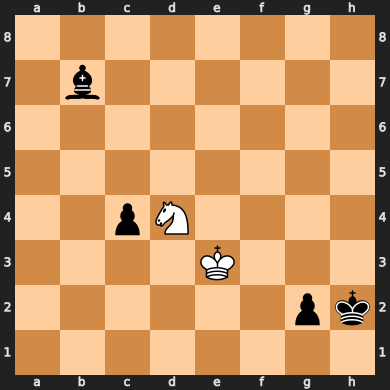

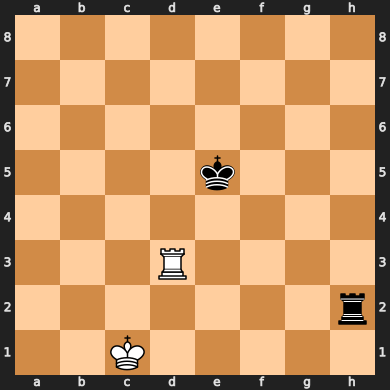

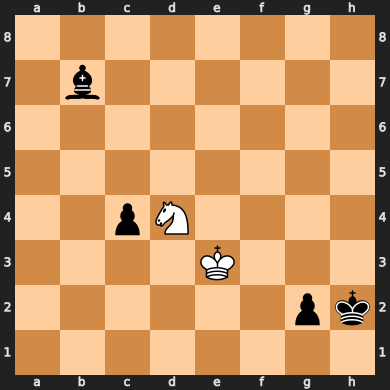

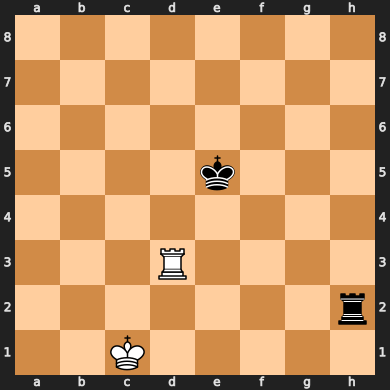

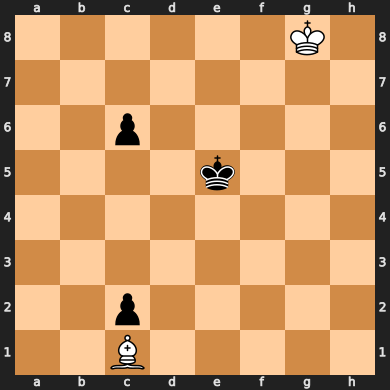

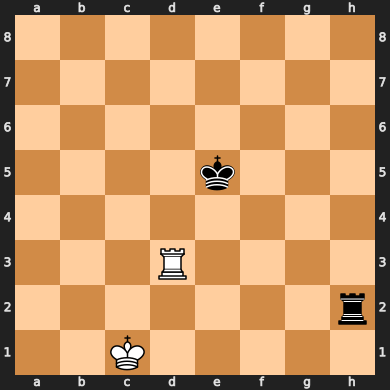

In [38]:
for x1, x2 in x_train[:3]:
    display(decode_embed(x1))
    display(decode_embed(x2))

SAVING THE SUBMODEL

In [22]:
submodel.save('fen_embed.h5')

In [16]:
model_old = tf.keras.models.load_model('old_fen_embed.keras')
model_new = tf.keras.models.load_model('fen_embed.keras')
old_pred = model_old.predict(tf.reshape(embed_fen('r2qkb1r/pp2nppp/3p4/2pNN1B1/2BnP3/3P4/PPP2PPP/R2bK2R w KQkq - 1 0'), (1, -1)))[0]
new_pred = model_new.predict(tf.reshape(embed_fen('r2qkb1r/pp2nppp/3p4/2pNN1B1/2BnP3/3P4/PPP2PPP/R2bK2R w KQkq - 1 0'), (1, -1)))[0]
old_pred - new_pred
#there is a difference in the model before and after training the outer_model whichb ensures that weights have been changed!

1/1 [==============================] - 0s 56ms/step


array([ 0.00000000e+00,  0.00000000e+00,  1.85925439e-01,  0.00000000e+00,
       -1.37931675e-01,  0.00000000e+00,  9.12813544e-02,  5.42865843e-02,
        4.04225290e-02,  0.00000000e+00, -6.50212690e-02,  8.03598762e-02,
        0.00000000e+00,  0.00000000e+00,  9.91803408e-03,  0.00000000e+00,
        0.00000000e+00,  6.39157593e-02,  8.25883001e-02, -1.15097433e-01,
        2.07446404e-02,  7.63096362e-02,  2.60561436e-01, -7.21738487e-02,
        2.18997762e-01,  0.00000000e+00, -1.74598396e-01, -2.80483663e-02,
       -1.29634798e-01, -2.58459985e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.69061154e-01,  5.20765036e-03,  7.54202753e-02,
       -3.18902314e-01,  0.00000000e+00,  0.00000000e+00, -1.94445595e-01,
       -1.73838526e-01, -6.32913932e-02, -2.37706110e-01,  0.00000000e+00,
       -7.86613822e-02,  5.90305477e-02,  8.75423476e-02, -2.18303621e-01,
       -5.85015379e-02,  4.22252417e-02, -3.64786983e-02,  0.00000000e+00,
        0.00000000e+00,  

In [41]:
model_old.predict(tf.reshape([0]*768, (1, -1)))[0]

1/1 [==============================] - 0s 134ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)